In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

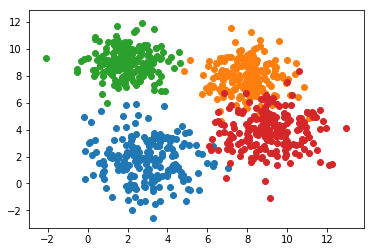

In [12]:
def createDataset(k, means, std, size=800):
    data = np.empty( (0,3) )
    for cluster in range(k):
        pts = np.random.normal(means[cluster], std[cluster], size=(size//k,2))
        pts = np.c_[pts, np.ones(size//k)*cluster ]
        data = np.append( data, pts, axis=0)
    np.random.shuffle(data)
    return data
data = createDataset( 4, [ (3,2), (8,8), (2,9), (9,4) ], [ 1.5, 1.1, 1, 1.4] )
for k in range(4):
    temp = data[:,0:2][data[:,2]==k]
    plt.scatter( temp[:,0], temp[:,1],  )

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split( data[:,0:2],data[:,2],test_size=0.2, stratify=data[:,2] )
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((640, 2), (160, 2), (640,), (160,))

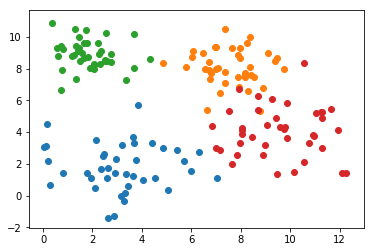

In [14]:
#our test data
for k in range(4):
    temp = X_test[Y_test==k]
    plt.scatter( temp[:,0], temp[:,1],  )

### Agglomerative Hierarchical clustering Technique: 

In this technique, initially each data point is considered as an individual cluster. At each iteration, the similar clusters merge with other clusters until one cluster or K clusters are formed.

The basic algorithm of Agglomerative is straight forward.
* Compute the proximity matrix
* Let each data point be a cluster
* Repeat: Merge the two similar clusters and update the proximity matrix
* Until only a single cluster remains

### HOW DO WE CALCULATE THE SIMILARITY BETWEEN TWO CLUSTERS?

#### Complete Linkage : 
> The similarity of two clusters C1 and C2 is equal to the maximum of the similarity between points Pi and Pj such that Pi belongs to C1 and Pj belongs to C2.

>Sim(C1,C2) = Max Sim(Pi,Pj) such that Pi ∈ C1 & Pj ∈ C2

#### Average Linkage : 
> Take all the pairs of points and compute their similarities and calculate the average of the similarities.

> sim(C1,C2) = ∑ sim(Pi, Pj)/|C1|*|C2| where, Pi ∈ C1 & Pj ∈ C2

#### Ward Linkage :
>  This approach of calculating the similarity between two clusters is exactly the same as Group Average except that Ward’s method calculates the sum of the square of the distances Pi and PJ.

> sim(C1,C2) = ∑ (dist(Pi, Pj))²/|C1|*|C2|


In [15]:
class AgglomerativeClustering():
    def __init__(self, n_clusters=2, affinity='euclidean', linkage='ward'):
        self.__n_clusters = n_clusters
        self.__proximity = []
        self.__affinity = { 'euclidean': self.__euclidean }[affinity]
        self.__linkage = { 'complete': self.__max_distance, 'average': self.__average_distance, 
                          'ward':self.__ward_distance}[linkage]
        self.__clusters = None
        self.__labels_ = None
    
    def __euclidean(self, X1, X2 ): return np.sqrt( np.sum( (X1-X2)**2, axis=1 )  )
    
    def __max_distance(self,distances, c1 ,c2): return max(distances)
    def __average_distance(self,distances, c1, c2): return np.sum(distances)/(c1*c2)
    def __ward_distance(self,distances, c1, c2 ): return np.sum( np.square(distances) )/(c1*c2)
    
    def __distances(self, g1, g2 ):
        all_distances = np.array([])
        for row in g1:
            all_distances = np.append( all_distances, self.__affinity(g2,row) )
        return all_distances
    
    def __computeProximityMatrix(self,n_clusters):
        self.__proximity = np.ones( (n_clusters,n_clusters) )*float('inf')
        for i in range(n_clusters-1):
            for j in range(i+1,n_clusters):
                g1, g2 = self.__clusters[i], self.__clusters[j]
                proximity = self.__linkage( self.__distances(g1,g2), len(g1), len(g2) )
                self.__proximity[i][j] = self.__proximity[j][i] = proximity
    
    def __findMinIndex(self):
        minimum, index = float('inf'), (None,None)
        size = len(self.__proximity)
        for i in range(size):
            j = np.argmin( self.__proximity[i] )
            if minimum > self.__proximity[i][j]: 
                minimum = self.__proximity[i][j]
                index = (i,j)
        return index
    
    def __updateProximityMatrixAndClusters(self,i,j,n):
        i,j = min(i,j),max(i,j)
        new_cluster = np.append( self.__clusters[i], self.__clusters[j], axis=0)
        self.__proximity = np.delete(self.__proximity,[i,j],axis=0)
        self.__proximity = np.delete(self.__proximity,[i,j],axis=1)
        self.__clusters = self.__clusters[:i]+self.__clusters[i+1: j]+self.__clusters[j+1:]+[new_cluster]
        infs = np.ones( (n-2,) )*float('inf')
        self.__proximity = np.c_[ self.__proximity, infs ]
        infs = np.ones( (1,n-1) )*float('inf')
        self.__proximity = np.append(self.__proximity, infs, axis=0)
        for i in range(n-2):
            g = self.__clusters[i]
            proximity = self.__linkage( self.__distances(  new_cluster, g ), len(new_cluster), len(g) )
            self.__proximity[i][n-2] = self.__proximity[n-2][i] = proximity
    
    def fit(self,X):
        self.__clusters = list( np.expand_dims( X_train, axis=1 ) )
        n_clusters = len(self.__clusters)
        self.__computeProximityMatrix(n_clusters)
        while n_clusters > self.__n_clusters:
            i,j = self.__findMinIndex()
            self.__updateProximityMatrixAndClusters(i,j,n_clusters)
            n_clusters = len(self.__clusters)
        self.__labels_ = self.predict(X)
    
    def predict(self,X):
        distances = self.__predict_distances(X)
        return np.argmin(distances, axis=1)
    
    def __predict_distances(self,X):
        X = np.expand_dims( X, axis=1 )
        distances = []
        for sample in X:
            sample_dist = []
            for i in range(self.__n_clusters):
                proximity = self.__linkage( self.__distances(  sample, self.__clusters[i] ), 
                                           1, len(self.__clusters[i]) )
                sample_dist.append(proximity)
            distances.append(sample_dist)
        return np.array(distances)
    
    def fit_predict(self,X):
        self.fit(X)
        return self.__labels_            

In [16]:
agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg.fit(X_train)

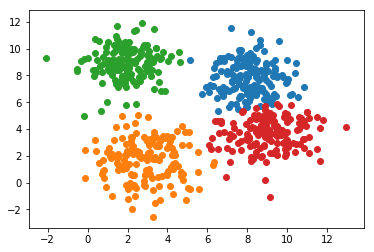

In [17]:
y_pred = agg.predict(X_train)
for k in range(4):
    temp = X_train[y_pred==k]
    plt.scatter( temp[:,0], temp[:,1],  )

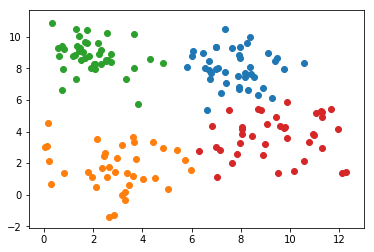

In [18]:
y_pred = agg.predict(X_test)
for k in range(4):
    temp = X_test[y_pred==k]
    plt.scatter( temp[:,0], temp[:,1],  )